In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import matplotlib as mpl

In [2]:
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

print("완료!")

완료!


In [3]:
# 데이터 확인
data = pd.read_csv('data/ChatbotData.csv')
data

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [4]:
#7622, 9906번 문장 오타 확인
print(data.iloc[7622])
print(data.iloc[9906])

Q        이별후 8개월이란 시간이 흐르고
A         다른 인연이 ㅊ자아올 거예요.
label                    1
Name: 7622, dtype: object
Q                                               사랑의 정의
A        내가 원하는 것보다 다른 사람이 원하는 것을 더 우선순위에 두넌 것이에요.-울라프
label                                                2
Name: 9906, dtype: object


In [5]:
# 오타 수정
data.iloc[7622, data.columns.get_loc("A")] = "다른 인연이 찾아올 거예요."
data.iloc[9906, data.columns.get_loc("A")] = "내가 원하는 것보다 다른 사람이 원하는 것을 더 우선순위에 두는 것이에요.-울라프"

In [6]:
#7622, 9906번 문장 오타 확인
print(data.iloc[7622])
print(data.iloc[9906])

Q        이별후 8개월이란 시간이 흐르고
A          다른 인연이 찾아올 거예요.
label                    1
Name: 7622, dtype: object
Q                                               사랑의 정의
A        내가 원하는 것보다 다른 사람이 원하는 것을 더 우선순위에 두는 것이에요.-울라프
label                                                2
Name: 9906, dtype: object


In [7]:
import re

In [8]:
# 특수기호 찾아내는 함수 생성

def find_all_special_chars(df):
    pattern = re.compile(r"[^a-zA-Z0-9가-힣.,!?]")
    all_text = " ".join(df.astype(str).values.flatten())
    special_chars = set(pattern.findall(all_text))

    return special_chars

In [9]:
# 사용된 특수기호 목록
special_chars = find_all_special_chars(data)
special_chars

{' ', '%', "'", '-', ';', '_', '~', '…', 'ㅋ', 'ㅎ', 'ㅜ', 'ㅠ'}

In [10]:
# 전처리 함수 생성

def preprocess_sentence(sentence):
    # 소문자화
    sentence = sentence.lower().strip()

    # 알파벳, 문장부호, 한글만 남기고 모두 제거
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅎㅏ-ㅣ가-힣0-9.,!?]", " ", sentence)
    
    # 'ㅋㅋㅋ','!!!' 등 1개 단어로 축약
    sentence = re.sub(r'([^a-zA-Z가-힣0-9])\1+', r'\1', sentence)

    # 문장 앞뒤의 불필요한 공백 제거
    sentence = re.sub(r"\s+", " ", sentence).strip()

    return sentence

In [11]:
# 전처리 테스트
test_text = '와 너무 배고프네....!!???   ㅠㅠㅠㅠㅠ'
print(preprocess_sentence(test_text))

와 너무 배고프네.!? ㅠ


In [12]:
# 전처리 함수 적용
data = data.astype(str).applymap(preprocess_sentence)

In [13]:
# 전체 데이터셋을 질문과 답변으로 분리
questions = data['Q']
answers = data['A']

In [14]:
from konlpy.tag import Mecab
from collections import OrderedDict

In [15]:
mecab = Mecab()

In [16]:
# mecab으로 토큰화할 때 최대 토큰 개수 확인 함수
def get_token_length(sentences, tokenizer):

    avg_length = 0
    max_length = 0
    for sentence in sentences:
        token_count = len(tokenizer(sentence))
        max_length = max(max_length, token_count)
        avg_length = np.mean(token_count)

    return print('최대 토큰 개수 : ', max_length, ', 평균 토큰 개수 : ', avg_length)

In [17]:
# 최대 토큰 문장 확인

mecab_tokenizer = mecab.morphs

src_length = get_token_length(questions, mecab_tokenizer)
tgt_length = get_token_length(answers, mecab_tokenizer)

src_length
tgt_length

최대 토큰 개수 :  32 , 평균 토큰 개수 :  4.0
최대 토큰 개수 :  40 , 평균 토큰 개수 :  10.0


In [18]:
import seaborn as sns

In [19]:
# 토큰 개수 분포 확인
def plot_token_length_distribution(sentences):
    # 문장별 토큰 개수 계산
    token_lengths = [len(mecab.morphs(sentence)) for sentence in sentences]

    # 그래프 스타일 설정
    plt.figure(figsize=(12, 5))

    # 히스토그램 (문장별 토큰 개수 분포)
    plt.subplot(1, 2, 1)
    sns.histplot(token_lengths, bins=30, kde=True, color="royalblue")
    plt.xlabel("Question 문장 별 토큰 개수")
    plt.ylabel("빈도수")
    plt.title("Question 문장별 토큰 길이 분포")

    plt.tight_layout()
    plt.show()

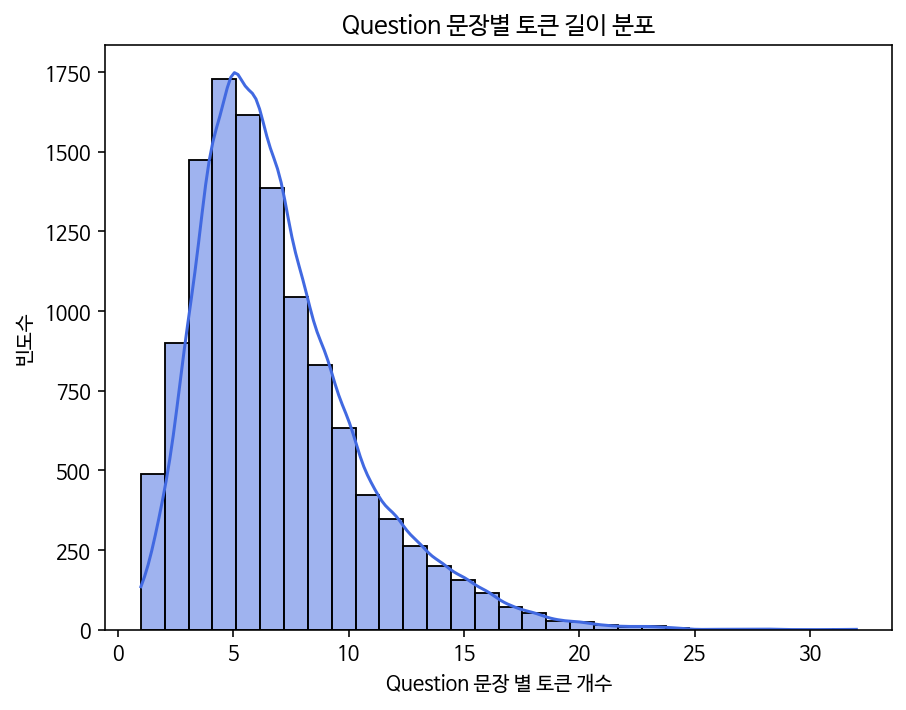

In [20]:
# 질문 문장 토큰 분포 확인
plot_token_length_distribution(questions)

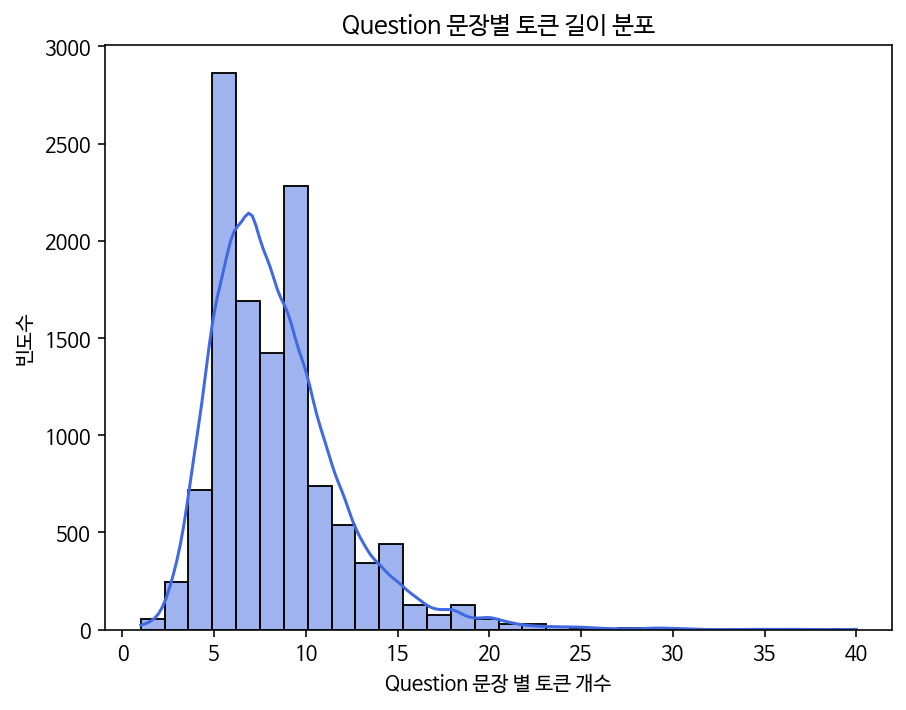

In [21]:
# 답변 문장 토큰 분포 확인
plot_token_length_distribution(answers)

##### mecab 기준 토큰 분포 확인
- 질문 문장의 최대 토큰 개수는 32, 평균 토큰 개수는 4
- 답변 문장의 최대 토큰 개수는 40, 평균 토큰 개수는 10
- 토큰 개수 15개를 기준으로 데이터에서 제외

In [22]:
# 데이터 토크나이징 함수

def build_corpus(src_sentences, tgt_sentences, tokenizer):

    assert len(src_sentences) == len(tgt_sentences)
    
    # 문장을 토큰화
    tokenized_sources = [tokenizer(sentence) for sentence in src_sentences]
    tokenized_targets = [tokenizer(sentence) for sentence in tgt_sentences]

    # 최대 길이를 초과하는 문장 제거
    filtered_data = [
        (src, tgt) for src, tgt in zip(tokenized_sources, tokenized_targets) 
        if len(src) <= 15 and len(tgt) <= 15
    ]

    # 중복 제거 (순서 유지)
    seen_src, seen_tgt = set(), set()
    unique_data = []
    
    for src, tgt in filtered_data:
        src_tuple, tgt_tuple = tuple(src), tuple(tgt)
        if src_tuple not in seen_src and tgt_tuple not in seen_tgt:
            unique_data.append((src, tgt))
            seen_src.add(src_tuple)
            seen_tgt.add(tgt_tuple)

    # 다시 리스트로 변환
    tokenized_sources, tokenized_targets = zip(*unique_data)

    return list(tokenized_sources), list(tokenized_targets)

In [23]:
que_corpus, ans_corpus = build_corpus(questions, answers, mecab_tokenizer)

In [24]:
len(que_corpus)

7089

In [25]:
len(ans_corpus)

7089

#### 데이터 증강
- Lexical Substitution으로 문장 당 하나의 단어를 변경(ko.bin파일의 유의어 활용)
- 문장당 하나의 단어를 랜덤하게 이동시키는 랜덤 스왑 적용
- 원본 데이터를 위 방법으로 3배로 늘릴 예정

In [26]:
que_corpus

[['12', '시', '땡', '!'],
 ['1', '지망', '학교', '떨어졌', '어'],
 ['3', '박', '4', '일', '놀', '러', '가', '고', '싶', '다'],
 ['ppl', '심하', '네'],
 ['sd', '카드', '망가졌', '어'],
 ['sns', '맞', '팔', '왜', '안', '하', '지', 'ㅠ'],
 ['sns', '시간', '낭비', '인', '거', '아', '는데', '매일', '하', '는', '중'],
 ['sns', '보', '면', '나', '만', '빼', '고', '다', '행복', '해', '보여'],
 ['가끔', '궁금', '해'],
 ['가끔', '은', '혼자', '인', '게', '좋', '다'],
 ['가난', '한', '자', '의', '설움'],
 ['가만', '있', '어도', '땀', '난다'],
 ['가상', '화폐', '쫄딱', '망함'],
 ['가스', '불', '켜', '고', '나갔', '어'],
 ['가스', '비', '너무', '많이', '나왔', '다', '.'],
 ['가스', '비', '비싼데', '감기', '걸리', '겠', '어'],
 ['가족', '여행', '가', '기', '로', '했', '어'],
 ['가족', '끼리', '여행', '간다', '.'],
 ['가족', '들', '보', '고', '싶', '어'],
 ['가족', '들', '이랑', '서먹', '해'],
 ['가족', '들', '이랑', '여행', '갈', '거', '야'],
 ['가족', '한테', '스트레스', '풀', '었', '어'],
 ['가출', '할까', '?'],
 ['가출', '해도', '갈', '데', '가', '없', '어'],
 ['간만에', '떨리', '니까', '좋', '더라'],
 ['간만에', '쇼핑', '중'],
 ['간만에', '휴식', '중'],
 ['간식', '뭐', '먹', '을까'],
 ['간장', '치킨', '시켜야', '지'],
 

In [27]:
ans_corpus

[['하루', '가', '또', '가', '네요', '.'],
 ['위로', '해', '드립니다', '.'],
 ['여행', '은', '언제나', '좋', '죠', '.'],
 ['눈살', '이', '찌푸려', '지', '죠', '.'],
 ['다시', '새로', '사', '는', '게', '마음', '편해요', '.'],
 ['잘', '모르', '고', '있', '을', '수', '도', '있', '어요', '.'],
 ['시간', '을', '정하', '고', '해', '보', '세요', '.'],
 ['자랑', '하', '는', '자리', '니까요', '.'],
 ['그', '사람', '도', '그럴', '거', '예요', '.'],
 ['혼자', '를', '즐기', '세요', '.'],
 ['돈', '은', '다시', '들어올', '거', '예요', '.'],
 ['땀', '을', '식혀', '주', '세요', '.'],
 ['어서', '잊', '고', '새', '출발', '하', '세요', '.'],
 ['빨리', '집', '에', '돌아가', '서', '끄', '고', '나오', '세요', '.'],
 ['다음', '달', '에', '는', '더', '절약', '해', '봐요', '.'],
 ['따뜻', '하', '게', '사세요', '!'],
 ['온', '가족', '이', '모두', '마음', '에', '드', '는', '곳', '으로', '가', '보', '세요', '.'],
 ['더', '가까워질', '기회', '가', '되', '겠', '네요', '.'],
 ['저', '도', '요', '.'],
 ['다', '들', '바빠서', '이야기', '할', '시간', '이', '부족', '했', '나', '봐요', '.'],
 ['좋', '은', '생각', '이', '에요', '.'],
 ['정말', '후회', '할', '습관', '이', '에요', '.'],
 ['무모', '한', '결정', '을', '내리', '지', '마세요', '.'],
 

In [28]:
from gensim.models import KeyedVectors
import gensim.downloader as api
from gensim.models import Word2Vec

In [29]:
import random
from tqdm import tqdm

In [30]:
#!pip install --upgrade gensim==3.8.3

In [31]:
wv = Word2Vec.load("data/ko.bin")

In [32]:
#model = KeyedVectors.load("data/ko.bin")
#wv = model.wv  # KeyedVectors 객체로 단어 벡터에 접근

In [33]:
# 유의어 확인 함수
def get_synonyms(word, topn=10):
    try:
        # 주어진 단어의 유사 단어 목록 반환
        similar_words = wv.most_similar(word, topn=topn)
        synonyms = [synonym for synonym, _ in similar_words]  # 유의어만 추출
        #print(f"'{word}'의 유의어 (상위 {topn}개):")

        return synonyms[0]
    
    except KeyError:
        #print(f"'{word}'는 모델 사전에 존재하지 않습니다.")
        
        return word

In [34]:
# 실제 단어 출력 가능 여부 확인
get_synonyms("예요")

/tmp/ipykernel_312/2877655179.py:5: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  similar_words = wv.most_similar(word, topn=topn)


'예요'

In [35]:
#  Lexical Substitution 함수
def lexical_substitution(tokenized_sentence, wv):
    # 토큰 리스트 복사
    new_sentence = tokenized_sentence.copy()
    
    # 단어 토큰만 추출 (구두점 및 조사 제외)
    words = [token for token in new_sentence]
    if not words:  # 단어가 없으면 원래 문장 반환
        return new_sentence
    
    # 랜덤으로 단어 선택
    selected_word = random.choice(words)
    synonym = get_synonyms(selected_word)  # 상위 1개 유의어 가져오기
    
    # 선택된 단어를 유의어로 대체
    for i, token in enumerate(new_sentence):
        if token == selected_word:
            new_sentence[i] = synonym
            break  # 첫 번째 매칭만 대체
    
    return new_sentence

In [36]:
# 위치 변경 함수
def swap_position(tokenized_sentence):
    # 토큰 리스트 복사
    new_sentence = tokenized_sentence.copy()
    
    # 단어 토큰만 추출 (구두점 및 조사 제외)
    words = [(i, token) for i, token in enumerate(new_sentence)]
    if len(words) < 2:  # 위치를 바꿀 단어가 2개 미만이면 원래 문장 반환
        return new_sentence
    
    # 두 개의 단어 위치를 랜덤 선택
    idx1, idx2 = random.sample([i for i, _ in words], 2)
    
    # 위치 스왑
    new_sentence[idx1], new_sentence[idx2] = new_sentence[idx2], new_sentence[idx1]
    
    return new_sentence

In [37]:
# 데이터 증강 테스트
augmented_test= []
for sentence in ans_corpus[:10]:
    # 원본 추가
    augmented_test.append(sentence)
    
    # Lexical Substitution 적용
    sub_sentence = lexical_substitution(sentence, wv)
    augmented_test.append(sub_sentence)
    
    # 위치 변경 적용
    swap_sentence = swap_position(sentence)
    augmented_test.append(swap_sentence)

# 결과 출력
for i, aug_sentence in enumerate(augmented_test):
    print(f"증강 문장 {i+1}: {aug_sentence}")

증강 문장 1: ['하루', '가', '또', '가', '네요', '.']
증강 문장 2: ['하루', '가', '또', '가', '네요', '는데']
증강 문장 3: ['하루', '.', '또', '가', '네요', '가']
증강 문장 4: ['위로', '해', '드립니다', '.']
증강 문장 5: ['위로', '해', '드립니다', '.']
증강 문장 6: ['드립니다', '해', '위로', '.']
증강 문장 7: ['여행', '은', '언제나', '좋', '죠', '.']
증강 문장 8: ['여행', '은', '언제나', '좋', '죠', '는데']
증강 문장 9: ['좋', '은', '언제나', '여행', '죠', '.']
증강 문장 10: ['눈살', '이', '찌푸려', '지', '죠', '.']
증강 문장 11: ['눈살', '이', '찌푸려', '지', '죠', '는데']
증강 문장 12: ['눈살', '이', '지', '찌푸려', '죠', '.']
증강 문장 13: ['다시', '새로', '사', '는', '게', '마음', '편해요', '.']
증강 문장 14: ['다시', '새로', '사', '는', '게', '마음', '편해요', '는데']
증강 문장 15: ['다시', '새로', '.', '는', '게', '마음', '편해요', '사']
증강 문장 16: ['잘', '모르', '고', '있', '을', '수', '도', '있', '어요', '.']
증강 문장 17: ['잘', '모르', '고', '있', '을', '수', '때문', '있', '어요', '.']
증강 문장 18: ['잘', '모르', '고', '수', '을', '있', '도', '있', '어요', '.']
증강 문장 19: ['시간', '을', '정하', '고', '해', '보', '세요', '.']
증강 문장 20: ['시간', '을', '정하', '기에', '해', '보', '세요', '.']
증강 문장 21: ['을', '시간', '정하', '고', '해', '보

/tmp/ipykernel_312/2877655179.py:5: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  similar_words = wv.most_similar(word, topn=topn)


In [38]:
# 데이터 증강 테스트
augmented_que_corpus= []
for que in tqdm(que_corpus):
    # 원본 추가
    augmented_que_corpus.append(que)
    #augmented_ans_corpus.append(ans)
    
    # Lexical Substitution 적용

    augmented_que_corpus.append(lexical_substitution(que, wv))
    #augmented_ans_corpus.append(lexical_substitution(ans, wv))
    
    # 위치 변경 적용
    augmented_que_corpus.append(swap_position(que))
    #augmented_ans_corpus.append(swap_position(ans))

  0%|          | 0/7089 [00:00<?, ?it/s]/tmp/ipykernel_312/2877655179.py:5: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  similar_words = wv.most_similar(word, topn=topn)
100%|██████████| 7089/7089 [00:13<00:00, 534.64it/s]


In [39]:
augmented_que_corpus[:9]

[['12', '시', '땡', '!'],
 ['12', '시', '땡', '캐치'],
 ['12', '!', '땡', '시'],
 ['1', '지망', '학교', '떨어졌', '어'],
 ['1', '지망', '학교', '떨어졌', '어'],
 ['1', '지망', '학교', '어', '떨어졌'],
 ['3', '박', '4', '일', '놀', '러', '가', '고', '싶', '다'],
 ['3', '박', '4', '일', '놀', '러', '가', '고', '싶', '으며'],
 ['3', '박', '4', '일', '놀', '러', '가', '고', '다', '싶']]

In [40]:
# 데이터 증강 테스트
augmented_ans_corpus= []
for ans in tqdm(ans_corpus):
    # 원본 추가
    augmented_ans_corpus.append(ans)
    
    # Lexical Substitution 적용
    augmented_ans_corpus.append(lexical_substitution(ans, wv))
    
    # 위치 변경 적용
    augmented_ans_corpus.append(swap_position(ans))

  0%|          | 0/7089 [00:00<?, ?it/s]/tmp/ipykernel_312/2877655179.py:5: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  similar_words = wv.most_similar(word, topn=topn)
100%|██████████| 7089/7089 [00:13<00:00, 522.92it/s]


In [41]:
augmented_ans_corpus[:9]

[['하루', '가', '또', '가', '네요', '.'],
 ['하루', '가', '또', '가', '네요', '는데'],
 ['네요', '가', '또', '가', '하루', '.'],
 ['위로', '해', '드립니다', '.'],
 ['위로', '해의', '드립니다', '.'],
 ['위로', '.', '드립니다', '해'],
 ['여행', '은', '언제나', '좋', '죠', '.'],
 ['항해', '은', '언제나', '좋', '죠', '.'],
 ['여행', '은', '언제나', '좋', '.', '죠']]

In [42]:
augmented_ans_corpus = [["<start>"] + sent + ["<end>"] for sent in augmented_ans_corpus]

In [43]:
augmented_ans_corpus[:9]

[['<start>', '하루', '가', '또', '가', '네요', '.', '<end>'],
 ['<start>', '하루', '가', '또', '가', '네요', '는데', '<end>'],
 ['<start>', '네요', '가', '또', '가', '하루', '.', '<end>'],
 ['<start>', '위로', '해', '드립니다', '.', '<end>'],
 ['<start>', '위로', '해의', '드립니다', '.', '<end>'],
 ['<start>', '위로', '.', '드립니다', '해', '<end>'],
 ['<start>', '여행', '은', '언제나', '좋', '죠', '.', '<end>'],
 ['<start>', '항해', '은', '언제나', '좋', '죠', '.', '<end>'],
 ['<start>', '여행', '은', '언제나', '좋', '.', '죠', '<end>']]

In [44]:
# 단어 사전 생성
all_tokens = set()
for sent in augmented_que_corpus + augmented_ans_corpus:
    all_tokens.update(sent)
word_to_index = {word: idx + 1 for idx, word in enumerate(sorted(all_tokens))}  # 0은 패딩용으로 예약
unk_index = len(word_to_index) + 1  # 현재 길이 + 1 (0은 패딩이므로 +1만 추가)
word_to_index['<unk>'] = unk_index
VOCAB_SIZE = len(word_to_index) + 1  # 패딩 토큰 포함

In [45]:
# 토큰을 정수로 변환
enc_sequences = [[word_to_index[token] for token in sent] for sent in augmented_que_corpus]
dec_sequences = [[word_to_index[token] for token in sent] for sent in augmented_ans_corpus]

In [46]:
enc_ndarray = tf.keras.preprocessing.sequence.pad_sequences(enc_sequences, padding='post')
dec_ndarray = tf.keras.preprocessing.sequence.pad_sequences(dec_sequences, padding='post')

In [47]:
BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices((enc_ndarray, dec_ndarray)).batch(batch_size=BATCH_SIZE)

In [48]:
# 모델 설계

In [49]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, (2*(i//2)) / np.float32(d_model))

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

In [50]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_lookahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_enc_mask = generate_padding_mask(src)

    dec_lookahead_mask = generate_lookahead_mask(tgt.shape[1])
    dec_tgt_padding_mask = generate_padding_mask(tgt)
    dec_mask = tf.maximum(dec_tgt_padding_mask, dec_lookahead_mask)

    return enc_mask, dec_enc_mask, dec_mask

In [51]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
        

    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x

    
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
                        
        out = self.combine_heads(out)
        out = self.linear(out)
            
        return out, attention_weights

In [52]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
            
        return out

In [53]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        '''
        Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

In [54]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        '''
        Masked Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        '''
        Multi-Head Attention
        '''
        residual = out
        out = self.norm_2(out)
        # Q, K, V 순서에 주의하세요!
        out, dec_enc_attn = self.enc_dec_attn(Q=out, K=enc_out, V=enc_out, mask=dec_enc_mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [55]:
class Encoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
    
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [56]:
class Decoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, dec_enc_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [57]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, dec_enc_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, dec_enc_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [58]:
transformer = Transformer(
    n_layers=4,
    d_model=512,
    n_heads=8,
    d_ff=2048,
    src_vocab_size=VOCAB_SIZE,
    tgt_vocab_size=VOCAB_SIZE,
    pos_len=200,
    dropout=0.3,
    shared_fc=True,
    shared_emb=True)

d_model = 512

In [59]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [60]:
learning_rate = LearningRateScheduler(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate,
                                        beta_1=0.9,
                                        beta_2=0.98, 
                                        epsilon=1e-9)

In [61]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [62]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]  # Decoder의 input
    gold = tgt[:, 1:]     # Decoder의 output과 비교하기 위해 right shift를 통해 생성한 최종 타겟

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

In [63]:
# Q. 위의 코드를 활용하여 모델을 훈련시켜봅시다!
EPOCHS = 25

for epoch in range(EPOCHS):
    total_loss = 0
    
    dataset_count = tf.data.experimental.cardinality(train_dataset).numpy()
    tqdm_bar = tqdm(total=dataset_count)
    for (batch, (src, tgt)) in enumerate(train_dataset):
        # Perform one training step
        batch_loss, enc_attns, dec_attns, dec_enc_attns = train_step(
            src,
            tgt,
            model=transformer,
            optimizer=optimizer
        )
        
        # Accumulate the loss
        total_loss += batch_loss
        
        # Update progress bar
        tqdm_bar.update(1)
        tqdm_bar.set_description(
            f"Epoch {epoch + 1} Batch {batch} Loss {batch_loss.numpy():.4f}"
        )
    
    # Calculate average loss for the epoch
    avg_loss = total_loss / dataset_count
    
    # Close the progress bar
    tqdm_bar.close()
    
    # Print epoch summary
    print(f'Epoch {epoch + 1} Loss {avg_loss:.4f}')

Epoch 1 Batch 332 Loss 5.2207: 100%|██████████| 333/333 [00:36<00:00,  9.11it/s]


Epoch 1 Loss 6.1519


Epoch 2 Batch 332 Loss 4.0448: 100%|██████████| 333/333 [00:26<00:00, 12.56it/s]


Epoch 2 Loss 4.5277


Epoch 3 Batch 332 Loss 2.8271: 100%|██████████| 333/333 [00:26<00:00, 12.39it/s]


Epoch 3 Loss 3.8310


Epoch 4 Batch 332 Loss 1.7153: 100%|██████████| 333/333 [00:26<00:00, 12.40it/s]


Epoch 4 Loss 3.1873


Epoch 5 Batch 332 Loss 1.4186: 100%|██████████| 333/333 [00:26<00:00, 12.49it/s]


Epoch 5 Loss 2.6147


Epoch 6 Batch 332 Loss 1.9679: 100%|██████████| 333/333 [00:26<00:00, 12.44it/s]


Epoch 6 Loss 2.2339


Epoch 7 Batch 332 Loss 1.4437: 100%|██████████| 333/333 [00:26<00:00, 12.42it/s]


Epoch 7 Loss 1.9335


Epoch 8 Batch 332 Loss 1.2121: 100%|██████████| 333/333 [00:26<00:00, 12.47it/s]


Epoch 8 Loss 1.7594


Epoch 9 Batch 332 Loss 1.3545: 100%|██████████| 333/333 [00:26<00:00, 12.53it/s]


Epoch 9 Loss 1.6583


Epoch 10 Batch 332 Loss 1.2678: 100%|██████████| 333/333 [00:26<00:00, 12.54it/s]


Epoch 10 Loss 1.5787


Epoch 11 Batch 332 Loss 1.0609: 100%|██████████| 333/333 [00:26<00:00, 12.53it/s]


Epoch 11 Loss 1.5510


Epoch 12 Batch 332 Loss 1.0169: 100%|██████████| 333/333 [00:26<00:00, 12.46it/s]


Epoch 12 Loss 1.5502


Epoch 13 Batch 332 Loss 1.2231: 100%|██████████| 333/333 [00:26<00:00, 12.52it/s]


Epoch 13 Loss 1.5024


Epoch 14 Batch 332 Loss 1.1867: 100%|██████████| 333/333 [00:26<00:00, 12.59it/s]


Epoch 14 Loss 1.3256


Epoch 15 Batch 332 Loss 1.0809: 100%|██████████| 333/333 [00:26<00:00, 12.52it/s]


Epoch 15 Loss 1.1725


Epoch 16 Batch 332 Loss 1.1025: 100%|██████████| 333/333 [00:26<00:00, 12.46it/s]


Epoch 16 Loss 1.0497


Epoch 17 Batch 332 Loss 0.6967: 100%|██████████| 333/333 [00:26<00:00, 12.51it/s]


Epoch 17 Loss 0.9427


Epoch 18 Batch 332 Loss 1.5332: 100%|██████████| 333/333 [00:26<00:00, 12.60it/s]


Epoch 18 Loss 0.8654


Epoch 19 Batch 332 Loss 0.6083: 100%|██████████| 333/333 [00:26<00:00, 12.62it/s]


Epoch 19 Loss 0.7878


Epoch 20 Batch 332 Loss 0.5656: 100%|██████████| 333/333 [00:26<00:00, 12.60it/s]


Epoch 20 Loss 0.7219


Epoch 21 Batch 332 Loss 0.6831: 100%|██████████| 333/333 [00:26<00:00, 12.61it/s]


Epoch 21 Loss 0.6773


Epoch 22 Batch 332 Loss 0.8272: 100%|██████████| 333/333 [00:26<00:00, 12.62it/s]


Epoch 22 Loss 0.6367


Epoch 23 Batch 332 Loss 0.7620: 100%|██████████| 333/333 [00:26<00:00, 12.63it/s]


Epoch 23 Loss 0.5956


Epoch 24 Batch 332 Loss 0.6523: 100%|██████████| 333/333 [00:26<00:00, 12.64it/s]


Epoch 24 Loss 0.5554


Epoch 25 Batch 332 Loss 0.5116: 100%|██████████| 333/333 [00:26<00:00, 12.63it/s]

Epoch 25 Loss 0.5305


In [64]:
ㅁ

NameError: name 'ᄆ' is not defined

In [65]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

In [67]:
def calculate_bleu(reference, candidate, weights=[0.25, 0.25, 0.25, 0.25]):
    return sentence_bleu([reference],
                         candidate,
                         weights=weights,
                         smoothing_function=SmoothingFunction().method1)  # smoothing_function 적용

In [68]:
MAX_LEN = 15

In [66]:
def translate(tokens, model, src_tokenizer, tgt_tokenizer):      
    padded_tokens = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=MAX_LEN,
                                                           padding='post')
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)   
    for i in range(MAX_LEN):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(padded_tokens, output)

        predictions, _, _, _ = model(padded_tokens, 
                                      output,
                                      enc_padding_mask,
                                      combined_mask,
                                      dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)  
            return result

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)  
    return result

In [78]:
index_to_word = {idx: word for word, idx in word_to_index.items()}  # 역방향 매핑 추가

In [76]:
def response(sentence, model, tokenizer):

    padded_tokens = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=MAX_LEN,
                                                           padding='post')
    ids = []
    output = tf.expand_dims([word_to_index['<start>']], 0)   
    for i in range(MAX_LEN):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(padded_tokens, output)

        predictions, _, _, _ = model(padded_tokens, 
                                      output,
                                      enc_padding_mask,
                                      combined_mask,
                                      dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)  
            return result

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)  
    return result

In [ ]:
response('배고파', transformer, mecab_tokenizer)

In [69]:
def eval_bleu_single(model, src_sentence, tgt_sentence, src_tokenizer, tgt_tokenizer, verbose=True):
    
    src_tokens = mecab_tokenizer(src_sentence)  # ['아', '배고파']
    tgt_tokens = mecab_tokenizer(tgt_sentence)  # ['얼마나', '배고프', '세요', '?']

    # 사전에 없는 토큰을 <unk>로 대체하며 ID로 변환
    src_ids = [word_to_index.get(token, word_to_index['<unk>']) for token in src_tokens]
    tgt_ids = [word_to_index.get(token, word_to_index['<unk>']) for token in tgt_tokens]

    if (len(src_tokens) > MAX_LEN): return None
    if (len(tgt_tokens) > MAX_LEN): return None

    reference = tgt_sentence.split()
    candidate = translate(src_tokens, model, src_tokenizer, tgt_tokenizer)

    score = sentence_bleu([reference], candidate,
                          smoothing_function=SmoothingFunction().method1)

    if verbose:
        print("Source Sentence: ", src_sentence)
        print("Model Prediction: ", candidate)
        print("Real: ", reference)
        print("Score: %lf\n" % score)
        
    return score
        
print('슝=3')

슝=3


In [70]:
def eval_bleu(model, src_sentences, tgt_sentence, src_tokenizer, tgt_tokenizer, verbose=True):
    total_score = 0.0
    sample_size = len(src_sentences)
    
    for idx in tqdm(range(sample_size)):
        score = eval_bleu_single(model, src_sentences[idx], tgt_sentence[idx], src_tokenizer, tgt_tokenizer, verbose)
        if not score: continue
        
        total_score += score
    
    print("Num of Sample:", sample_size)
    print("Total Score:", total_score / sample_size)

In [72]:
mecab_tokenizer('아 배고파')

['아', '배고파']

In [73]:
src_tokens = [word_to_index[token] for token in mecab_tokenizer('아 배고파.')]
src_tokens

[3903, 2735, 3]

In [74]:
eval_bleu_single(transformer, 
                 "배고파", 
                 "얼마나 배고파요?", 
                 mecab_tokenizer, 
                 mecab_tokenizer)

ValueError: invalid literal for int() with base 10: '배고파'

In [ ]:
test_text = ["가끔 뭐하는지 궁금해",
        "오늘 일찍 일어났더니 피곤하다.",
        "간만에 여자친구랑 데이트 하기로 했어.",
        "집에 있는다는 소리야."]

In [ ]:
# 평가 함수에 입력과 타겟으로 쓰이는 문장을 토크나이징, 정수화하는 부분 수정 필요